### Importing the required libraries

In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import lxml
import requests
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

*For this analysis we need data about Toronto and its suburbs which includes the names of the borough,neighbourhoods along with postal codes of each neighbourhood. We will get this data by webscraping from Wikipedia using BeautifulSoup.*

### Webscraping using BeautifulSoup

In [3]:
#Webscraping data using beautiful soup
url= 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html=requests.get(url)
soup= BeautifulSoup(html.text, 'lxml')

### Creating the datasets

*Transforming this data into a pandas dataframe. For this we create an empty dataframe first.*

In [4]:
df= pd.DataFrame(columns = ['PostalCode','Borough','Neighborhood'])

*Next, we loop through the data and fill the dataframe one row at a time*

In [5]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})


*Our created dataframe looks as follows:*

In [6]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


*Next, we check for any 'Not Assigned' values in the dataset*

In [7]:
#Checking for not assigned values in borough
if any(df['Borough'] =='Not assigned'):
    print('There are not assigned values in borough')
else:
    print('There are no not assigned values in borough')

There are no not assigned values in borough


In [8]:
#Checking for not assigned values in neighborhood
if any(df['Neighborhood'] =='Not assigned'):
    print('There are not assigned values in neighborhood')
else:
    print('There are no not assigned values in neighbourhood')

There are no not assigned values in neighbourhood


In [9]:
df.shape

(103, 3)

*Getting the latitudes and longitudes of Toronto neighborhoods*

In [10]:
geo_coords= pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')

In [11]:

geo1= geo_coords.rename(columns= {'Postal Code':'PostalCode'})

*Merging the latitudes and longitudes dataset with the neighborhoods dataset*

In [12]:
df1 = pd.merge(df, geo1, how='inner', on=['PostalCode'])

In [13]:
df1.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [14]:
df1.shape

(103, 5)

*Getting the nearby venues data of Toronto from Four square*

In [15]:
nearby_venues1 = pd.read_json("https://raw.githubusercontent.com/ibm-developer-skills-network/yczvh-DataFilesForIBMProjects/master/segmenting_neighborhoods.json")    
nearby_venues1.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                 'Venue', 
                 'Venue Latitude', 
                 'Venue Longitude', 
                 'Venue Category']
Toronto_venues=nearby_venues1

*The nearby venues data set looks as follows:*

In [14]:
Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant


In [16]:
Toronto_venues.shape

(1337, 7)

*It has 1337 rows and 7 columns*

*Checking the different types of venues present in the dataset*

In [17]:
Toronto_venues['Venue Category'].unique()

array(['Fast Food Restaurant', 'Bar', 'Bank', 'Electronics Store',
       'Restaurant', 'Mexican Restaurant', 'Rental Car Location',
       'Medical Center', 'Breakfast Spot', 'Coffee Shop',
       'Korean BBQ Restaurant', 'Soccer Field', 'Hakka Restaurant',
       'Caribbean Restaurant', 'Thai Restaurant', 'Athletics & Sports',
       'Bakery', 'Gas Station', 'Lounge', 'Fried Chicken Joint',
       'Playground', 'Department Store', 'Convenience Store',
       'Hobby Shop', 'Bus Station', 'Ice Cream Shop', 'Bus Line',
       'Metro Station', 'Park', 'Motel', 'American Restaurant', 'Café',
       'General Entertainment', 'Farm', 'Skating Rink', 'College Stadium',
       'Indian Restaurant', 'Chinese Restaurant', 'Vietnamese Restaurant',
       'Pet Store', 'Light Rail Station', 'Gaming Cafe', 'Sandwich Place',
       'Middle Eastern Restaurant', 'Shopping Mall', 'Smoke Shop',
       'Auto Garage', 'Latin American Restaurant', 'Italian Restaurant',
       'Noodle House', 'Pizza Place', '

*Keeping only the 'Restaurants' in the 'Venue Category' as we are only interested in them and removing the other venues.*

In [20]:
toronto_restaurants = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)

In [21]:
toronto_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
3,Woburn,43.770992,-79.216917,Korean Grill House,43.770812,-79.214502,Korean BBQ Restaurant
4,Cedarbrae,43.773136,-79.239476,Federick Restaurant,43.774697,-79.241142,Hakka Restaurant


In [23]:
toronto_restaurants.shape

(295, 7)

*There are 295 rows in the new dataset which implies that there are 295 restaurants located in Toronto*

### Visualising the location of restaurants in Toronto on a map

*Plotting these restaurants on the map of Toronto we can visualise how they are located*

In [159]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[43.6532 , -79.3832], zoom_start=10)

# add markers to map
for lat, lng, venue, neighborhood in zip(toronto_restaurants['Venue Latitude'], toronto_restaurants['Venue Longitude'], toronto_restaurants['Venue Category'], toronto_restaurants['Neighborhood']):
    label = '{}, {}'.format(venue, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

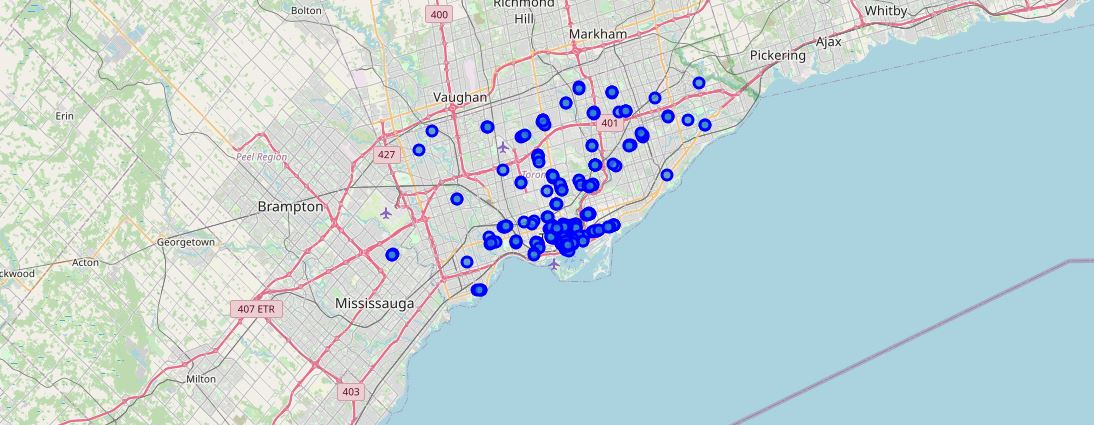

### Creating a Bar chart to see the number of restaurants in each neighbourhood

*We create a dataset with the count of restaurants in each neighbourhood*

In [24]:
bardata = toronto_restaurants.groupby('Neighborhood').count()
bardata1= bardata[['Venue Category']]
bardata1

,Venue Category
Neighborhood,
Agincourt,1
"Bathurst Manor, Wilson Heights, Downsview North",4
Bayview Village,2
"Bedford Park, Lawrence Manor East",9
Berczy Park,7
...,...
Victoria Village,2
Westmount,2
"Wexford, Maryvale",3


*Plotting this data in a bar chart*

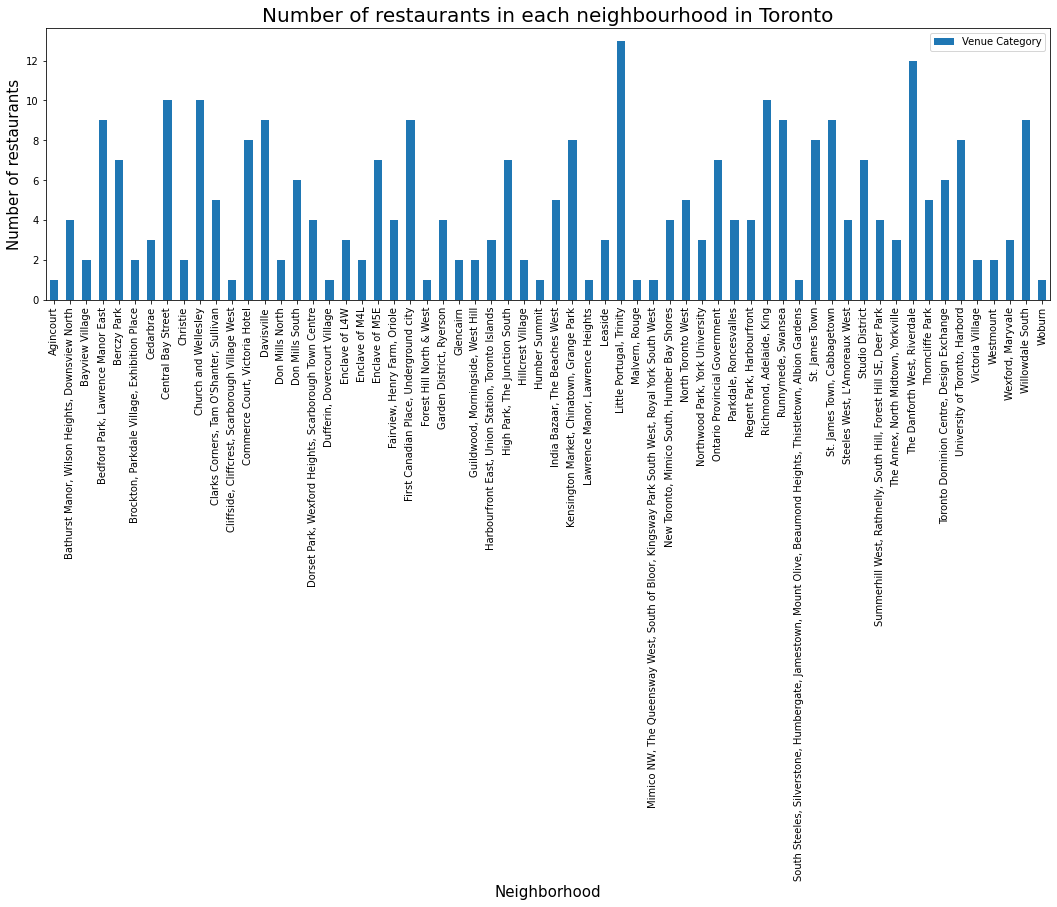

In [53]:
bardata1.plot(kind='bar', figsize=(18,5))
                                   
plt.title('Number of restaurants in each neighbourhood in Toronto',fontsize=20)
plt.xlabel('Neighborhood',fontsize=15)
plt.ylabel('Number of restaurants',fontsize=15)
plt.show()

*Sorting this data we can easily see the neighborhoods having less restaurants and those having many restaurants*

In [25]:
bardata_sorted= bardata1.sort_values('Venue Category')
bardata_sorted

,Venue Category
Neighborhood,
Agincourt,1
"South Steeles, Silverstone, Humbergate, Jamestown, Mount Olive, Beaumond Heights, Thistletown, Albion Gardens",1
"Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West",1
"Malvern, Rouge",1
"Lawrence Manor, Lawrence Heights",1
...,...
Church and Wellesley,10
"Richmond, Adelaide, King",10
Central Bay Street,10


*Plotting the sorted data as a bar chart makes it easier to read the chart*

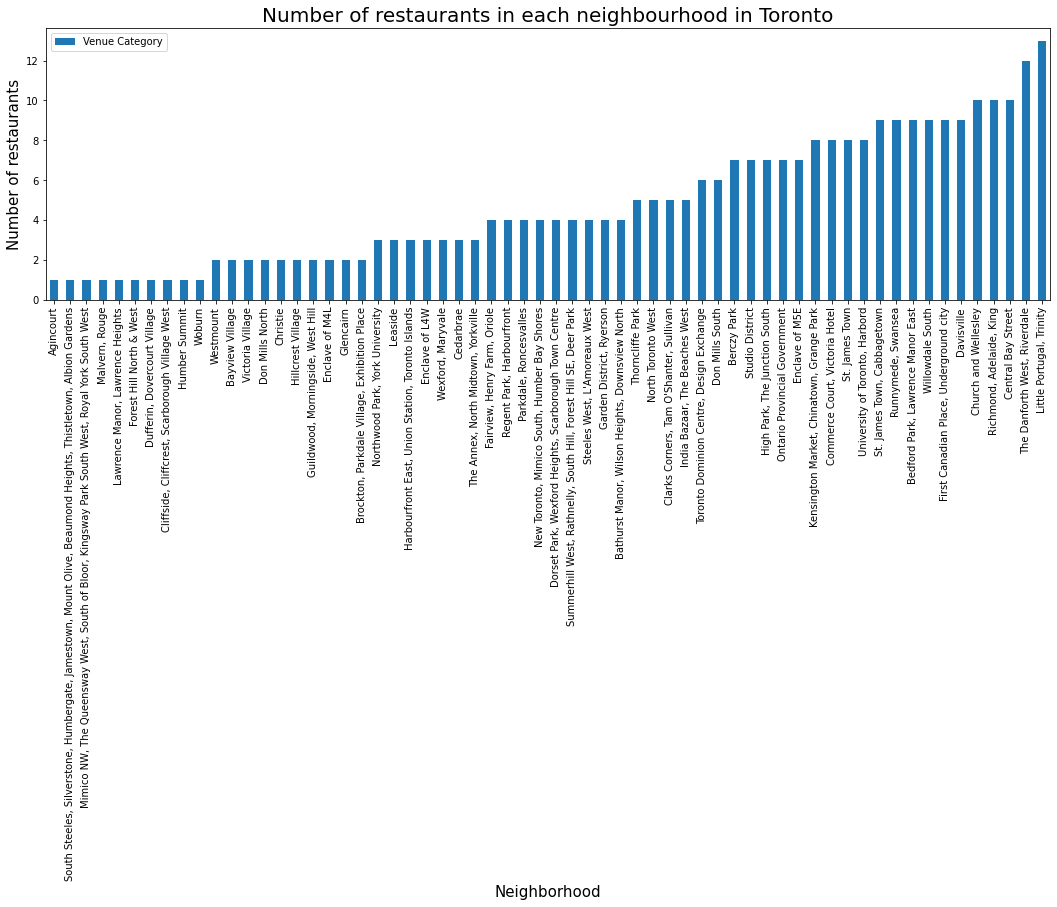

In [54]:
bardata_sorted.plot(kind='bar', figsize=(18,5))
                                   
plt.title('Number of restaurants in each neighbourhood in Toronto', fontsize=20)
plt.xlabel('Neighborhood', fontsize=15)
plt.ylabel('Number of restaurants', fontsize=15)
plt.show()

### Checking how many different types of restaurants are present in our dataset

In [33]:
print('There are {} unique categories of restaurants'.format(len(toronto_restaurants['Venue Category'].unique())))

There are 40 unique categories of restaurants


In [56]:
data_type = toronto_restaurants['Venue Category'].value_counts()
data_type

Restaurant                       40
Italian Restaurant               27
Fast Food Restaurant             19
Sushi Restaurant                 18
Japanese Restaurant              18
Thai Restaurant                  15
American Restaurant              14
Seafood Restaurant               13
Greek Restaurant                 12
Middle Eastern Restaurant        12
Mexican Restaurant               11
Vietnamese Restaurant            10
Indian Restaurant                 9
Vegetarian / Vegan Restaurant     9
Chinese Restaurant                8
French Restaurant                 7
Comfort Food Restaurant           6
Ramen Restaurant                  6
Caribbean Restaurant              6
Asian Restaurant                  5
New American Restaurant           4
Latin American Restaurant         3
Mediterranean Restaurant          2
Cuban Restaurant                  2
Gluten-free Restaurant            2
Falafel Restaurant                2
Portuguese Restaurant             2
Dim Sum Restaurant          

Text(0, 0.5, 'Number of Restaurants')

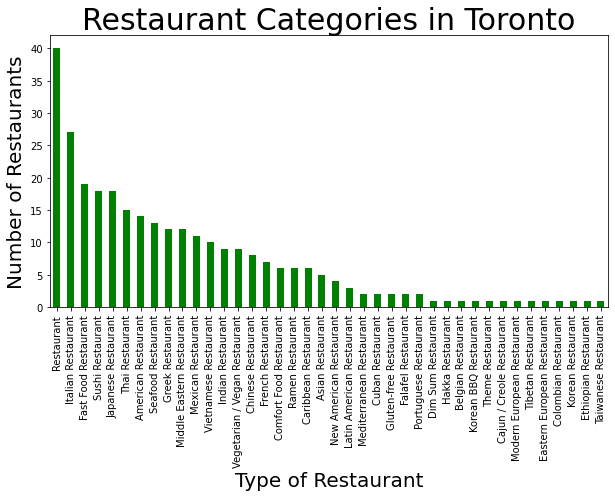

In [46]:
data_type.plot(kind='bar', figsize=(10,5), color ='green')

plt.title('Restaurant Categories in Toronto', fontsize=30)
plt.xlabel('Type of Restaurant',fontsize=20)
plt.ylabel('Number of Restaurants',fontsize=20)

### Creating Dummy Variables for each restaurant type

#### One hot encoding

In [160]:

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_restaurants[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighbourhood'] =  toronto_restaurants['Neighborhood']
final=toronto_onehot.set_index('Neighbourhood')
final.reset_index().head()


,Neighbourhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,...,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Woburn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cedarbrae,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Calculating the average of each type of restaurant located in each neighbourhood

*Calculating the mean of restaurant types grouped by neighbourhood*

In [67]:
restaurants_grouped = final.groupby('Neighbourhood').mean().reset_index()
restaurants_grouped

,Neighbourhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,...,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Agincourt,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,...,0.000000,0.250000,0.000000,0.250000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,Bayview Village,0.000000,0.0,0.0,0.0,0.0,0.50,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,"Bedford Park, Lawrence Manor East",0.111111,0.0,0.0,0.0,0.0,0.00,0.0,0.111111,0.0,...,0.000000,0.111111,0.000000,0.111111,0.0,0.111111,0.0,0.0,0.000000,0.000000
4,Berczy Park,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.142857,0.0,...,0.000000,0.142857,0.285714,0.000000,0.0,0.142857,0.0,0.0,0.142857,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Victoria Village,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
58,Westmount,0.000000,0.0,0.0,0.0,0.0,0.50,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
59,"Wexford, Maryvale",0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.333333
60,Willowdale South,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,...,0.333333,0.111111,0.000000,0.111111,0.0,0.000000,0.0,0.0,0.000000,0.111111


In [68]:
restaurants_grouped.shape

(62, 41)

##### Finding Top 5 restaurant types for each neighbourhood

In [70]:
num_top_venues = 5

for hood in restaurants_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = restaurants_grouped[restaurants_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['restaurant type','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
             restaurant type  freq
0  Latin American Restaurant   1.0
1        American Restaurant   0.0
2           Asian Restaurant   0.0
3          Korean Restaurant   0.0
4   Mediterranean Restaurant   0.0


----Bathurst Manor, Wilson Heights, Downsview North----
             restaurant type  freq
0                 Restaurant  0.25
1         Chinese Restaurant  0.25
2  Middle Eastern Restaurant  0.25
3           Sushi Restaurant  0.25
4           Ramen Restaurant  0.00


----Bayview Village----
             restaurant type  freq
0        Japanese Restaurant   0.5
1         Chinese Restaurant   0.5
2           Ramen Restaurant   0.0
3  Latin American Restaurant   0.0
4   Mediterranean Restaurant   0.0


----Bedford Park, Lawrence Manor East----
           restaurant type  freq
0       Italian Restaurant  0.22
1      American Restaurant  0.11
2        Indian Restaurant  0.11
3          Thai Restaurant  0.11
4  Comfort Food Restaurant  0.11


----Berczy Park----
    

### Defining a Function to sort restaurants in descending order

In [71]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Creating a new dataframe to show top 5 restaurant types for each neighborhood

In [115]:
num_top_venues =5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
neighborhoods_restaurants_sorted = pd.DataFrame(columns=columns)
neighborhoods_restaurants_sorted['Neighbourhood'] = restaurants_grouped['Neighbourhood']

for ind in np.arange(restaurants_grouped.shape[0]):
    neighborhoods_restaurants_sorted.iloc[ind, 1:] = return_most_common_venues(restaurants_grouped.iloc[ind, :], num_top_venues)

neighborhoods_restaurants_sorted.head()

,Neighbourhood,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
0,Agincourt,Latin American Restaurant,Vietnamese Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant
1,"Bathurst Manor, Wilson Heights, Downsview North",Sushi Restaurant,Chinese Restaurant,Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant
2,Bayview Village,Japanese Restaurant,Chinese Restaurant,Eastern European Restaurant,Hakka Restaurant,Greek Restaurant
3,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sushi Restaurant,Comfort Food Restaurant,Greek Restaurant,Indian Restaurant
4,Berczy Park,Seafood Restaurant,Comfort Food Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,French Restaurant


In [116]:
neighborhoods_restaurants_sorted.shape

(62, 6)

## Clustering neighbourhoods based on the similarity of restaurant types

### Clustering using K Means


*The neighbourhoods will be clustered based on a set of similar characteristics, in this case based on similarity in types of restaurants present.
K-Means clustering, which is used in this part of the analysis, is a machine learning algorithm that creates homogeneous subgroups/clusters from unlabeled data such that data points in each cluster are as similar as possible to each other according to a similarity measure (e.g., Euclidian distance).*

*Selecting the features (X): all Restaurant type columns from the restaurants_grouped dataframe.*

In [87]:
X = restaurants_grouped.drop('Neighbourhood', 1)

*Before proceeding, we need to determine the optimum value of k (number of clusters).* 

*The **Elbow Method** below calculates the sum of squared distances of data points to their closest centroid (cluster center) for different values of k. The optimal value of k is the one after which there is a plateau (no significant decrease in sum of squared distances).*

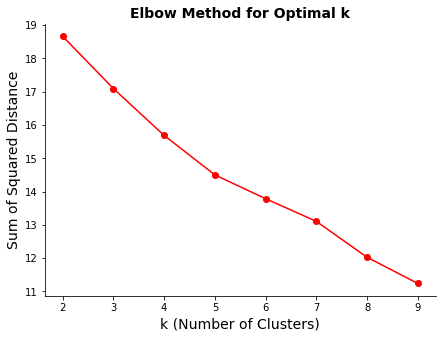

In [93]:
k_range = range(2,10)  # Range of k values to test
ssd = []  # Sum of Squared Distance

for k in k_range:
    model = KMeans(n_clusters=k).fit(X)
    ssd.append(model.inertia_)

plt.figure(figsize=(7,5))
plt.plot(k_range, ssd, 'ro-')
plt.title('Elbow Method for Optimal k', size=14, weight='bold')
plt.xlabel('k (Number of Clusters)', size=14)
plt.ylabel('Sum of Squared Distance', size=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('elbow.png', dpi=300, bbox_inches='tight')
plt.show()


##### Because there is no conspicuous "elbow" from the plot, another measure will be used: Silhouette Score.

Silhouette score varies from -1 to 1. A score value of 1 means the cluster is dense and well-separated from other clusters. A value nearing 0 represents overlapping clusters, data points are close to the decision boundary of neighboring clusters. A negative score indicates that the samples might have been assigned into the wrong clusters.

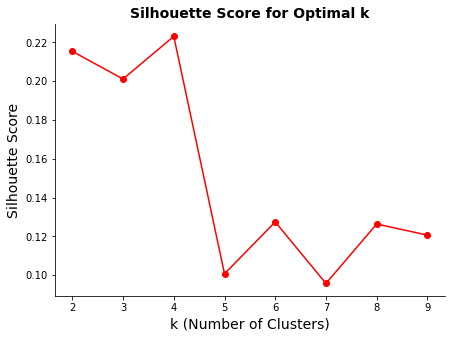

In [92]:
k_silh = range(2,10)
silh = []

for k in k_silh:
    model = KMeans(n_clusters=k).fit(X)
    labels = model.labels_
    silh.append(silhouette_score(X, labels, metric='euclidean'))

plt.figure(figsize=(7,5))
plt.plot(k_silh, silh, 'ro-')
plt.title('Silhouette Score for Optimal k', size=14, weight='bold')
plt.xlabel('k (Number of Clusters)', size=14)
plt.ylabel('Silhouette Score', size=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('silhouette.png', dpi=300, bbox_inches='tight')
plt.show()

 ***From the plot above, there is a peak at k = 4. We will proceed with that value as the number of optimal clusters.***

##### Calculating K Means with k = 4

In [103]:
k = 4 # number of clusters

# Run K-Means algorithm
model = KMeans(n_clusters=k).fit(X)
model.labels_ # Cluster labels generated for each row

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 3, 1, 1, 2, 1, 1, 3, 3, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1], dtype=int32)

#### Adding Cluster Labels to the dataset

In [118]:

# add clustering labels
neighborhoods_restaurants_sorted.insert(0, 'Cluster Labels', model.labels_)



In [119]:
restaurants_merged = df1.rename(columns={'Neighborhood':'Neighbourhood'})

restaurants_merged =restaurants_merged.join(neighborhoods_restaurants_sorted.set_index('Neighbourhood'), on='Neighbourhood')

restaurants_merged.head() 

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
0,M3A,North York,Parkwoods,43.753259,-79.329656,NaN,NaN,NaN,NaN,NaN,NaN
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Portuguese Restaurant,French Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Greek Restaurant,French Restaurant,Mexican Restaurant,Restaurant,Vietnamese Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1.0,Sushi Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Restaurant


In [125]:
restaurants_merged.shape

(103, 11)

*Removing Nan Values from the above dataset*

In [132]:
restaurants_merge= restaurants_merged.dropna().reset_index(drop=True)

In [133]:
restaurants_merge.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
0,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Portuguese Restaurant,French Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant
1,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Greek Restaurant,French Restaurant,Mexican Restaurant,Restaurant,Vietnamese Restaurant
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant
3,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1.0,Sushi Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Restaurant
4,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0.0,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Hakka Restaurant,Greek Restaurant


*Changing the cluster labels to type 'integer'*

In [152]:
# change cluster values to integer
restaurants_merge['Cluster Labels'] = restaurants_merge['Cluster Labels'].astype(int)
restaurants_merge

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
0,M4A,North York,Victoria Village,43.725882,-79.315572,1,Portuguese Restaurant,French Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant
1,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Greek Restaurant,French Restaurant,Mexican Restaurant,Restaurant,Vietnamese Restaurant
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant
3,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1,Sushi Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Restaurant
4,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Hakka Restaurant,Greek Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
57,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,1,Italian Restaurant,Restaurant,Taiwanese Restaurant,Japanese Restaurant,Caribbean Restaurant
58,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,1,Restaurant,Seafood Restaurant,American Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant
59,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1,Italian Restaurant,Theme Restaurant,Thai Restaurant,Indian Restaurant,Sushi Restaurant
60,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558,0,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant


## Visualising the clusters on the map of Toronto

In [157]:
# create map
map_clusters = folium.Map(location=[43.6532 , -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(restaurants_merge['Latitude'],restaurants_merge['Longitude'], restaurants_merge['Neighbourhood'], restaurants_merge['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

![map2.JPG](attachment:map2.JPG)

## Examining the clusters
*We can examine each cluster and determine the discriminating restaurant categories that distinguish each cluster*


In [144]:
restaurants_merge.loc[restaurants_merge['Cluster Labels'] == 0, restaurants_merge.columns[[1,2] + list(range(5, restaurants_merge.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
4,Scarborough,"Malvern, Rouge",0.0,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Hakka Restaurant,Greek Restaurant
17,North York,Hillcrest Village,0.0,Mediterranean Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Indian Restaurant,Greek Restaurant
30,East Toronto,"India Bazaar, The Beaches West",0.0,Fast Food Restaurant,Italian Restaurant,Sushi Restaurant,Restaurant,Dim Sum Restaurant
50,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",0.0,Fast Food Restaurant,Italian Restaurant,Thai Restaurant,Chinese Restaurant,Dim Sum Restaurant
54,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",0.0,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Hakka Restaurant,Greek Restaurant
55,Scarborough,"Steeles West, L'Amoreaux West",0.0,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hakka Restaurant
60,East Toronto Business,Enclave of M4L,0.0,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant
61,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",0.0,Fast Food Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Hakka Restaurant,Greek Restaurant


### Neighbourhoods in the first cluster seem to have 'Fast Food Restaurants' and Asian cuisine restaurants (such as Vietnamese, Dim Sum, Chinese, Sushi) as the most common type present

In [145]:
restaurants_merge.loc[restaurants_merge['Cluster Labels'] == 1, restaurants_merge.columns[[1,2] + list(range(5, restaurants_merge.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
0,North York,Victoria Village,1.0,Portuguese Restaurant,French Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant
1,Downtown Toronto,"Regent Park, Harbourfront",1.0,Greek Restaurant,French Restaurant,Mexican Restaurant,Restaurant,Vietnamese Restaurant
2,North York,"Lawrence Manor, Lawrence Heights",1.0,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant
3,Queen's Park,Ontario Provincial Government,1.0,Sushi Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Restaurant
6,Downtown Toronto,"Garden District, Ryerson",1.0,Thai Restaurant,Fast Food Restaurant,Mexican Restaurant,Ramen Restaurant,Vietnamese Restaurant
7,North York,Glencairn,1.0,Japanese Restaurant,Sushi Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant
8,North York,Don Mills South,1.0,Restaurant,Italian Restaurant,Asian Restaurant,Chinese Restaurant,Dim Sum Restaurant
9,Downtown Toronto,St. James Town,1.0,Italian Restaurant,Restaurant,Japanese Restaurant,Latin American Restaurant,Middle Eastern Restaurant
10,Scarborough,"Guildwood, Morningside, West Hill",1.0,Mexican Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant
11,Downtown Toronto,Berczy Park,1.0,Seafood Restaurant,Comfort Food Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,French Restaurant


### The second cluster seems to have a heady mix of all types of restaurants - Most of the neighbourhoods in this cluster are located in or near the downtown area of Toronto, which being a central commercial area, has many restaurants. Hence we can see that many different categories of restaurants can be found here.




In [146]:
restaurants_merge.loc[restaurants_merge['Cluster Labels'] == 2, restaurants_merge.columns[[1,2] + list(range(5, restaurants_merge.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
5,North York,Don Mills North,2.0,Japanese Restaurant,Caribbean Restaurant,Eastern European Restaurant,Hakka Restaurant,Greek Restaurant
16,Scarborough,Cedarbrae,2.0,Hakka Restaurant,Thai Restaurant,Caribbean Restaurant,Dim Sum Restaurant,Greek Restaurant
23,North York,"Northwood Park, York University",2.0,Vietnamese Restaurant,Caribbean Restaurant,Falafel Restaurant,Eastern European Restaurant,Hakka Restaurant
32,North York,Humber Summit,2.0,Caribbean Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Hakka Restaurant,Greek Restaurant


### The third cluster has 'Caribbean' and 'Asian'  (Japanese,Vietnamese, Hakka,etc) cuisine restaurants as the most common type.

In [147]:
restaurants_merge.loc[restaurants_merge['Cluster Labels'] == 3, restaurants_merge.columns[[1,2] + list(range(5, restaurants_merge.shape[1]))]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
21,West Toronto,"Dufferin, Dovercourt Village",3.0,Middle Eastern Restaurant,Vietnamese Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant
33,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",3.0,American Restaurant,Vegetarian / Vegan Restaurant,Hakka Restaurant,Greek Restaurant,Gluten-free Restaurant
34,East Toronto,Studio District,3.0,American Restaurant,Seafood Restaurant,Comfort Food Restaurant,Middle Eastern Restaurant,Italian Restaurant
40,Etobicoke,Westmount,3.0,Chinese Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Greek Restaurant
41,Scarborough,"Wexford, Maryvale",3.0,Middle Eastern Restaurant,Vietnamese Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant
43,Central Toronto,"The Annex, North Midtown, Yorkville",3.0,Asian Restaurant,Middle Eastern Restaurant,Indian Restaurant,Vietnamese Restaurant,Eastern European Restaurant
45,Mississauga,Enclave of L4W,3.0,American Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Eastern European Restaurant,Greek Restaurant


### The fourth cluster has  'American' and Middle Eastern restaurants as the most common type. This cluster also has many Mediterranean and Greek Restaurants.